# Investigating How Housing Value Correlates with SAT Scores in New York City
- Author: John Mays
- For: NYC Mayor's Office of Management and Budget
## Introduction:
### Motivation:
In America, there are many schools where students excel and many where they do not.  There are many hypotheses as to why this is and what the cause is.  The most common one in America is probably that students with less resources do not learn as well, simply as products of their environment, which would suggest that school outcomes are somehow correlated with wealth.  But, there are many others.  Getting to the truth of the matter would be very helpful for policy & decisionmaking on the parts of governments and schools, as well as American society in general.
### Research Question:
I would like to do a very limited study of this question with:
- New York City as a microcosmic testing area
- SAT score as an approximate indicator of successful schooling
- Local residential property value as an approximate indicator of an area's wealth
- ZIP codes as atomic area units

I recognize that some of these assumptions and assertions may introduce statistical faults, which will be addressed in the [Statistical Faults and Caveats](investigation.ipynb#statistical-faults-and-caveats) section at the end of this notebook.
## Code Setup:

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression

In [2]:
mpl.rcParams['figure.dpi'] = 100

### Importing Data:
_Note: All data is from [NYC OpenData](https://opendata.cityofnewyork.us/). For more information on data, see README_

In [3]:
prices = pd.concat([pd.read_excel('../data/2010_queens.xls', header=3),
                    pd.read_excel('../data/2010_bronx.xls', header=3),
                    pd.read_excel('../data/2010_brooklyn.xls', header=3),
                    pd.read_excel('../data/2010_manhattan.xls', header=3),
                    pd.read_excel('../data/2010_statenisland.xls', header=3)
                    ])
SAT_scores = pd.read_csv('../data/SAT__College_Board__2010_School_Level_Results_20231216.csv')
full_high_schools = pd.read_csv('../data/2014_-_2015_DOE_High_School_Directory_20231216.csv')
zip_boundaries = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA)_20231216.geojson')

In [4]:
# For filtering acceptable types of sales (residential):
residential_building_class_categories = [
   '01  ONE FAMILY HOMES                        ',
   '02  TWO FAMILY HOMES                        ',
   '03  THREE FAMILY HOMES                      ',
   '12  CONDOS - WALKUP APARTMENTS              ',
   '04  TAX CLASS 1 CONDOS                      ',
   '07  RENTALS - WALKUP APARTMENTS             ',
   '08  RENTALS - ELEVATOR APARTMENTS           ',
   '09  COOPS - WALKUP APARTMENTS               ',
   '10  COOPS - ELEVATOR APARTMENTS             ',
   '13  CONDOS - ELEVATOR APARTMENTS            '
]

### Brief Data Summary:
_Note:_ This dataset is not perfect. It would have better served the purposes of this experiment to consider a wider range of years or even a variable like `income` in place of `housing prices`, but this is the best dataset I could assemble using what is available on NYC OpenData.

__Four datasets are being used:__
1. `prices` is a list of property sales in NYC for the year 2010.  It holds property location and the type of property (which will serve to distinguish between residential and non-residential sales).  Each row is a sale.
2. `SAT_scores` holds recorded mean SAT subject scores from the year 2010.  It also holds the high school's "DBN" (district borough number), a unique identifying code, and the number of test takers. Each row is one high school.
3. `full_high_schools` is a directory of high schools in NYC.  It has the zip code of each high school.  Each row is one high school
4. `zip_boundaries` Contains a polygonal outline of each ZIP code in NYC.  The polygon's points are given as coordinates.  Each row is a ZIP code.

In [5]:
for df, name in zip([prices, SAT_scores, full_high_schools, zip_boundaries],
              ['prices', 'SAT scores', 'full_high_schools', 'zip_boundaries']):
    print(f'{name} has {len(df.index)} rows.')

prices has 69036 rows.
SAT scores has 460 rows.
full_high_schools has 435 rows.
zip_boundaries has 178 rows.


### Cleaning & Formatting Data:

In [6]:
# Filtering out non-residential sales, restricting to relevant columns,
# and finding median sale price for each ZIP code:
prices = prices[prices['BUILDING CLASS CATEGORY'].isin(
    residential_building_class_categories)]
prices = prices[['ZIP CODE', 'SALE PRICE']]
prices = prices[prices['SALE PRICE'] != 0]
mean_prices = prices.groupby('ZIP CODE').mean()
median_prices = prices.groupby('ZIP CODE').median()

In [7]:
# Restricting to relevant columns and renaming (for ease of join):
high_schools = full_high_schools.copy()
high_schools.rename({'dbn': 'DBN', 'postcode': 'ZIP CODE'}, axis=1,
                    inplace=True)
high_schools = high_schools[['DBN', 'ZIP CODE']]

In [8]:
# Restricting to relevant columns and renaming (for ease of join):
zip_boundaries = zip_boundaries.loc[:, ('modzcta', 'geometry')]
zip_boundaries.rename({'modzcta': 'ZIP CODE'}, axis=1, inplace=True)
zip_boundaries['ZIP CODE'] = zip_boundaries['ZIP CODE'].astype('int64')

## Merging into one DataFrame indexed by ZIP Code:
### Creating a DataFrame with Mean SAT Score by ZIP Code:

In [9]:
# Joing: adding ZIP code to SAT DataFrame by the DBN:
# note: DBN (district borough number) is a unique ID for schools in NYC
SAT_with_ZIP = SAT_scores.join(high_schools.set_index('DBN'), on='DBN', how='inner')

The code below implements this formula and stores the output in a dataframe (indexed by ZIP):

_Note: In 2010, total SAT score was simply a sum of the three subject scores._
$$score\_mean_{zip} = \frac{\sum_{school \in zip} num\_test\_takers_{school} (reading\_mean_{school} + math\_mean_{school} + writing\_mean_{school})}{num\_test\_takers_{zip}}$$

In [10]:
# Restricting to relevant columns and removing rows with missing data:
SAT_with_ZIP = SAT_with_ZIP[['Number of Test Takers', 'Critical Reading Mean',
                            'Mathematics Mean', 'Writing Mean', 'ZIP CODE']]
SAT_with_ZIP = SAT_with_ZIP.dropna()
# Temporarily scaling scores by number of test takers:
SAT_with_ZIP['Critical Reading Mean'] *= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Mathematics Mean'] *= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Writing Mean'] *= SAT_with_ZIP['Number of Test Takers']
# Summing weighted scores per ZIP:
SAT_with_ZIP = SAT_with_ZIP.groupby('ZIP CODE').sum()
# Averaging the 3 subject score means:
SAT_with_ZIP['SAT Score Mean'] = (SAT_with_ZIP['Critical Reading Mean']
                                  + SAT_with_ZIP['Mathematics Mean']
                                  + SAT_with_ZIP['Writing Mean'])
# Normalizing by total number of test takers to obtain average,
# then restricting to the only relevant column:
SAT_with_ZIP['SAT Score Mean'] /= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP = SAT_with_ZIP['SAT Score Mean']

In [11]:
SAT_with_ZIP.head()

ZIP CODE
10002    1414.411960
10003    1328.214076
10004    1370.353846
10006    1355.769231
10009    1251.000000
Name: SAT Score Mean, dtype: float64

### Merging Zip Boundaries with Mean Housing Prices:

In [12]:
boundaries_with_prices = zip_boundaries.set_index('ZIP CODE').join(median_prices, on='ZIP CODE', how='inner')

In [13]:
boundaries_with_prices.head()

,geometry,SALE PRICE
ZIP CODE,,
10001,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 ...",1200000.0
10002,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ...",610000.0
10003,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ...",996500.0
10026,"MULTIPOLYGON (((-73.96201 40.80551, -73.96007 ...",645000.0
10004,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ...",722957.0


### Total Merge:

In [14]:
total_df = boundaries_with_prices.join(SAT_with_ZIP, how='inner',
                                       on='ZIP CODE')

In [15]:
total_df.head()

,geometry,SALE PRICE,SAT Score Mean
ZIP CODE,,,
10002,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ...",610000.0,1414.411960
10003,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ...",996500.0,1328.214076
10026,"MULTIPOLYGON (((-73.96201 40.80551, -73.96007 ...",645000.0,1155.940594
10004,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ...",722957.0,1370.353846
10006,"MULTIPOLYGON (((-74.01251 40.70677, -74.01325 ...",529000.0,1355.769231


In [16]:
print(f'No. of ZIP Codes with SAT Scores: {SAT_with_ZIP.shape[0]}')
print(f'No. of ZIP Codes with Residential Sales Data: {boundaries_with_prices.shape[0]}')
print(f'No. of ZIPs left after inner join: {total_df.shape[0]}')

No. of ZIP Codes with SAT Scores: 108
No. of ZIP Codes with Residential Sales Data: 176
No. of ZIPs left after inner join: 108


_Note: Quite a few of the zip codes in NYC were lost after the join that was just performed.  All of them had at least some residential living spaces to gather housing price from, but many did not have even one high school._

## Analysis:
### Quickly Looking at Geography and Distributions:

In [17]:
inferno = plt.cm.inferno # a universal colormap

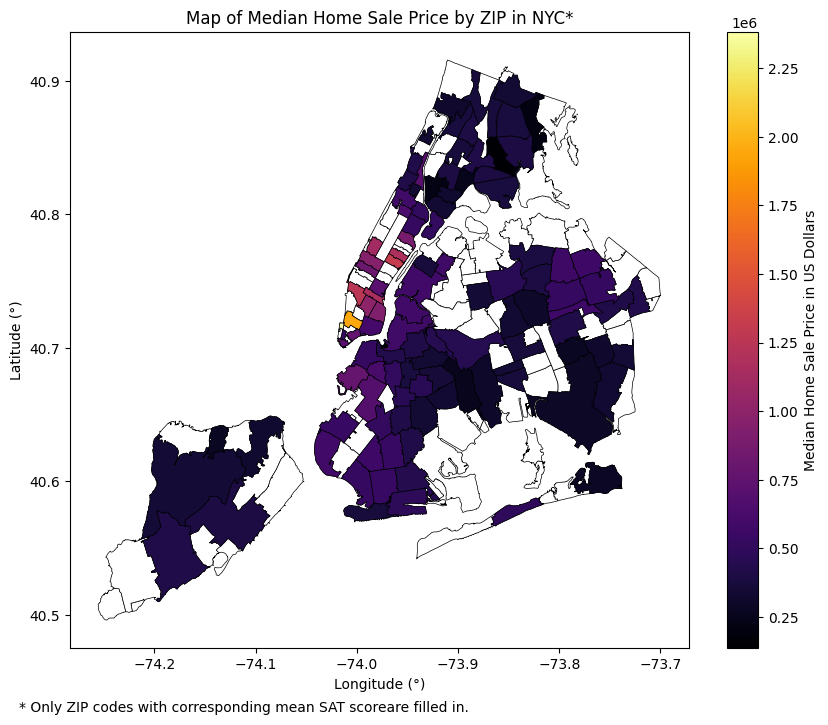

In [18]:
fig, ax = plt.subplots(1, figsize=(10, 8))
line_width = 0.5
zip_boundaries.plot(edgecolor=inferno(0), color='white', linewidth=line_width,
                    ax=ax),
total_df.plot(column='SALE PRICE', cmap=inferno,ax=ax,
              edgecolor=inferno(0), linewidth=line_width)
plt.colorbar(
    plt.cm.ScalarMappable(
        cmap=inferno, norm=plt.Normalize(
            vmin=total_df['SALE PRICE'].min(),
            vmax=total_df['SALE PRICE'].max())), ax=ax, label="Median Home "
            "Sale Price in US Dollars")
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.title('Map of Median Home Sale Price by ZIP in NYC*')
plt.figtext(0.075, 0.03, "* Only ZIP codes with corresponding mean SAT score"
            "are filled in.", ha="left", fontsize=10)
plt.show();

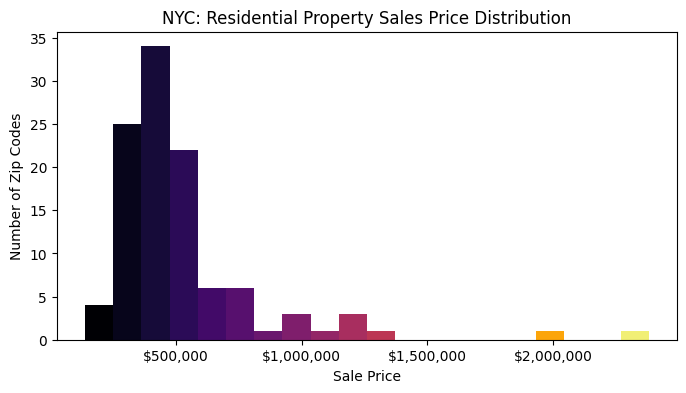

In [19]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
N, bins, patches = ax.hist(total_df['SALE PRICE'], bins=20)

fracs = bins / bins.max()
norm = mpl.colors.Normalize(fracs.min(), fracs.max())
for frac, patch in zip(fracs, patches):
    color = inferno(norm(frac))
    patch.set_facecolor(color)

plt.ylabel('Number of Zip Codes')
plt.xlabel('Sale Price')
plt.title('NYC: Residential Property Sales Price Distribution')
plt.show();

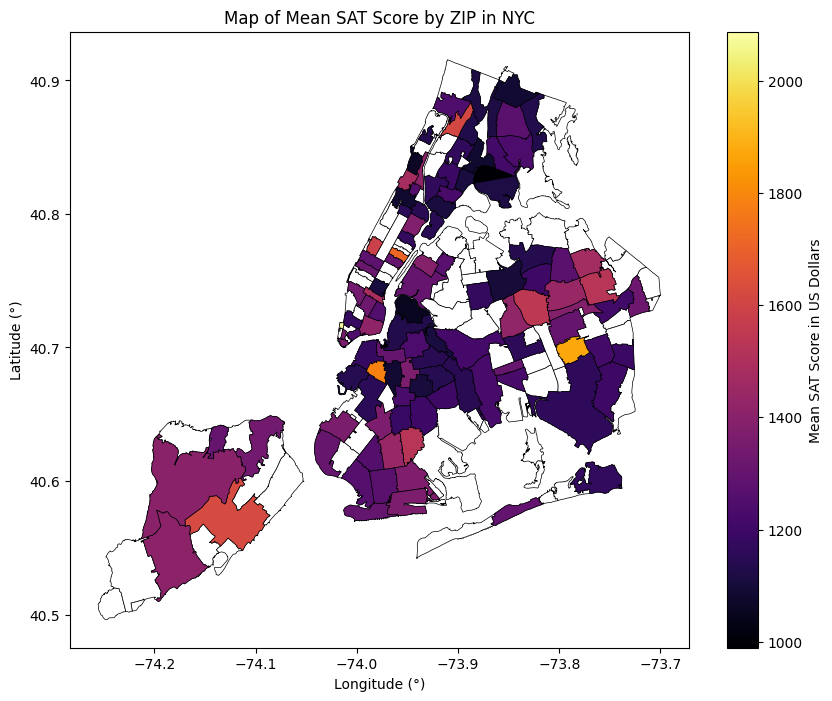

In [20]:
fig, ax=plt.subplots(1, figsize=(10, 8))
line_width=0.5
zip_boundaries.plot(edgecolor=inferno(0), color='white', linewidth=line_width,
                    ax=ax)
total_df.plot(column='SAT Score Mean', cmap=inferno, edgecolor=inferno(0),
              linewidth=line_width, ax=ax)
plt.colorbar(
    plt.cm.ScalarMappable(
        cmap=inferno, norm=plt.Normalize(
            vmin=total_df['SAT Score Mean'].min(), 
            vmax=total_df['SAT Score Mean'].max())),
        ax=ax, label='Mean SAT Score in US Dollars')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.title('Map of Mean SAT Score by ZIP in NYC')
plt.show();

### Looking for a Relationship:
Goal: To see how strongly and in what way our independent variable (Housing Price) and dependent variable (SAT) are related to one another.

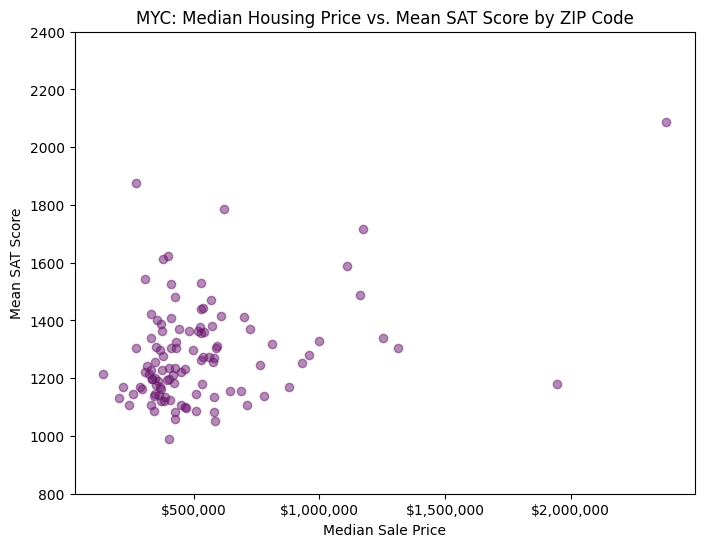

In [21]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
ax.scatter(total_df['SALE PRICE'], total_df['SAT Score Mean'],
           color=inferno(0.3), alpha=0.5)
plt.ylabel('Mean SAT Score')
plt.xlabel('Median Sale Price')
plt.title('MYC: Median Housing Price vs. Mean SAT Score by ZIP Code')
plt.ylim((800, 2400))
plt.show();

The outlier in the top right is an accelerated public school in Manhattan: Stuyvesant HS:

In [22]:
total_df[total_df['SAT Score Mean'] == total_df['SAT Score Mean'].max()]

,geometry,SALE PRICE,SAT Score Mean
ZIP CODE,,,
10282,"MULTIPOLYGON (((-74.01762 40.71365, -74.01754 ...",2381432.0,2087.0


In [23]:
full_high_schools[full_high_schools['postcode'] == 10282][['school_name', 'borough']]

,school_name,borough
81,Stuyvesant High School,Manhattan


There appears to either be no correlation or a very weak positive correlation.  Although, the single outlier, Stuyvesant High School, at nearly a 2100 SAT score is giving a lot of visual credit to this hypothesis.  It may be tempting to use a model resistant to outliers, such as a support vector machine or a random sample consensus regression (RANSAC), in order to test this hypothesis.  However, the meaning of _"resistant to outliers"_ can be easily misconstrued: In this case, outliers are points that would lie far outside the model function (exerting significant & sometimes unwanted influence on the function).  Therefore, if there was a positive-slope regression function that closely predicted the data point up at 2100, that point would no longer be considered an outlier.  On the other hand, if a negative-slope regression were created, it is possible that it would be.  Generally speaking, however, the model has more say that the user does on what is actually considered an outlier.

Let's run a linear regression and some trials of RANSAC (a non-deterministic algorithm) to see what kind of models are created.
### Regressions:

In [24]:
r_regressor = RANSACRegressor(max_trials=5000)
l_regressor = LinearRegression()

In [25]:
X = np.reshape(total_df['SALE PRICE'], (total_df['SALE PRICE'].shape[0], 1))
y = total_df['SAT Score Mean']

In [26]:
l_regressor.fit(X, y)
print(f'Linear Regression Score: {l_regressor.score(X, y)}')

Linear Regression Score: 0.1472712704161775


Mean RANSAC Regression Score: 0.13532546418661914


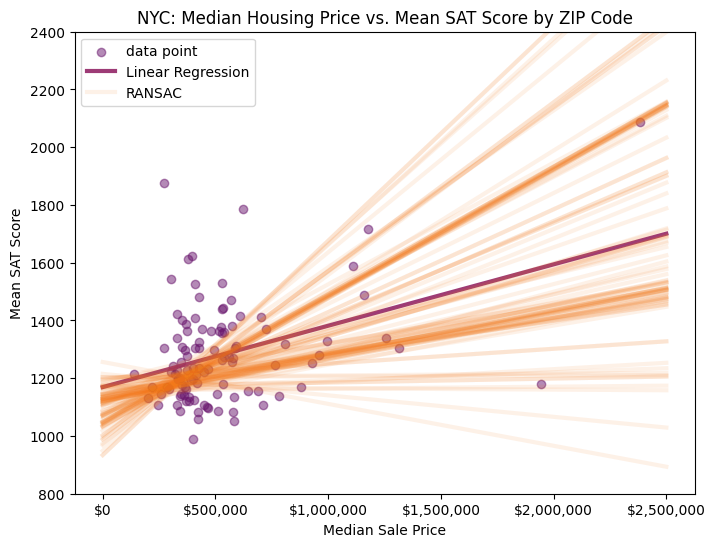

In [27]:
x_range = [0, 2.5e6]

fig, ax = plt.subplots(1, figsize=(8, 6))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
ax.scatter(total_df['SALE PRICE'], total_df['SAT Score Mean'],
           color=inferno(0.3), alpha=0.5, label='data point')
plt.plot(x_range, list(map(lambda x: l_regressor.predict([[x,]]),x_range)),
         color=inferno(0.4), linewidth=3, alpha=0.9,
         label='Linear Regression')
ransac_scores = []
for trial in range(100):
    r_regressor.fit(X, y)
    ransac_scores.append(np.abs(r_regressor.score(X, y)))
    if trial == 0:
        plt.plot(x_range,
                 list(map(lambda x: r_regressor.predict([[x,]]),x_range)),
                 color=inferno(0.7), linewidth=3, alpha=0.1, label='RANSAC')
    else:
        plt.plot(x_range,
                 list(map(lambda x: r_regressor.predict([[x,]]), x_range)),
            color=inferno(0.7), linewidth=3, alpha=0.1)
print(f'Mean RANSAC Regression Score: {np.mean(ransac_scores)}')
plt.ylabel('Mean SAT Score')
plt.xlabel('Median Sale Price')
plt.ylim((800, 2400))
plt.legend()
plt.title('NYC: Median Housing Price vs. Mean SAT Score by ZIP Code')
plt.show();

Note: The same methods were attempted with a log transform on the Median Sale Price variable, but both methods' performance was negatively affected:
- log(Linear) Regression Score: 0.10271442356617533
- log(RANSAC) Mean Score: 0.10376862340248022 

The code was removed for the sake of brevity.

## Results and Discussion:
The results of RANSAC and Linear Regression both suggest a positive linear relationship between residential building sale price and SAT scores, but the confidence scores are so low (~14%) that it warrants further investigation, and certainly doesn't allow for any ability to meaningfully predict one from another.

This data exhibits a much weaker relationship than was originally hypothesized. However, there are many potential sources of error and bias (see [Statistical Faults and Caveats](investigation.ipynb#statistical-faults-and-caveats) section).  If addressed, a potentially much stronger, much weaker, or totally different relationship may be revealed.  For now, the results of this study should be seen as somewhat suggestive of the hypothesized relationship, but generally inconclusive.

## Statistical Faults and Caveats:
The relationship observed in this notebook is subject to change if sources of bias and errors are addressed.
1. __Housing prices and wealth:__ This method of looking at housing prices as an analog to wealth has several caveats to consider.
    - Only housing _sales_ were considered in the dataset.  There may be many areas where the homes being sold do not necessarily reflect the general housing price (most homes are not being sold)
    - Housing price must not necessarily correlate to residents' wealth.
    - Housing price must not necessarily correlate to the expected meaningful effects of wealth like safety, sanity, and resources.
2. __SAT and area:__ There are less [school districts](https://schoolsearch.schools.nyc/) than zip codes, and they do not always have common boundaries. There are most likely many cases in which high schoolers who live in one ZIP code go to school in another, which would introduce plenty of error into the method of using ZIP codes as area units used in this notebook.
3. __Bias introduced by time:__ The SAT scores and housing prices were taken just two years after the housing crisis in the U.S.A. (2010).  Both may be abnormal or biased because of this.
4. __New York City and The U.S.A.:__ New York may not be representative of this relationship in the entire U.S.A. and it would be unwise to draw definitive conclusions on a larger area simply based on the results of N.Y.C.
5. __SAT and quality of education:__ SAT is only one part of academics in high school and may not reflect the full value of education or any one specific value such as career prospects after high school.
## Possible Improvements & Further Research:
If this question were to be investigated further, I would encourage several modifications.  I would suggest looking at data over a longer time scale (at least 5 years) to minimize fault #3.  I would suggest looking at median income or rent prices instead of home sales to address fault #1.  In the same vein, I would also choose to eliminate zip code units and instead look at an radius in blocks or feet around a school's address to better attach that value to the SAT scores, which would ease statistical faults #1 and #2.  Finally, I would at least investigate other measures of academic performance, like state testing, graduation, or matriculation rate.